In [1]:
import os
import glob
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
import astropy.io.fits as fits

import pyklip.klip as klip
import pyklip.fakes as fakes
import pyklip.instruments.MagAO as MagAO
import pyklip.parallelized as parallelized

#from scipy import ndimage
from importlib import reload

#if you get number of open file errors, it's probably because "open files" below is small (e.g. 256 by default).
#To fix this, close the notebook and terminate the python process with control + c in the terminal
# Type ulimit -n 10000 in the terminal and then restart the notebook process with jupyter notebook
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 10000
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 709
virtual memory          (kbytes, -v) unlimited


# Inject Fakes and run KLIP on these data

Nominally, all you should have to change in this notebook to generate a new contrast measurement is the directory name and prefix in the cell below. It will run through the fake planet injection, recovery, throughput calculation, and contrast calculation and write out a file called {prefix}_contrast.fits

In [2]:
#if need to add missing header keywords before running KLIP, uncomment this cell and fill in RA, Dec, wl, Peak, FWHM
#import pyklip_headers as pykh
#pykh.addradec('./sliced_Cont_80pctcut',RA, Dec)
#pykh.addwl('./sliced_Cont_80pctcut', wl)
#pykh.addstarpeak('./sliced_Cont_80pctcut', peak, FWHM, debug=True)

In [3]:
### directory where sliced data lives
direc = './sliced_Cont_80pctcut'
###load data - CHANGE FOR EACH WFE REDUCTION
filelist = glob.glob(direc+"/sliced*.fits")
# sorts file list so it's sequential
filelist = sorted(filelist, key=len)

### set up naming and saving. modify according to which KLIP parameters you're running (e.g. a1m4) and dataset above
#CHANGE FOR EACH REDUCTION OR YOUR FILES WILL BE OVERWRITTEN
#Naming scheme is object_date_cut_wl_klipparams
prefix = "hd169142_8Apr14_80pctcut_cont_a3m6_iwa10"

### CHANGE FOR EACH DATE/DATASET
### NOTE THAT THIS DIRECTORY NEEDS TO EXIST ALREADY, so create it by hand
outputdir = "./contrastcurves" 
prefix_fakes = prefix + '_FAKES'

### pull the values of the star peak from the headers
starpeak = []
for i in np.arange(len(filelist)):
    head = fits.getheader(filelist[i])
    starpeak.append(head["STARPEAK"])

### specify KLIP parameters here. note filename prefix above should match this
#annuli parameter
numann = 3
#movement parameter
movm = 4
#KL modes to extract. Can be a list
KLlist= [50]
#Inner Working Angle
IWA = 8

In [4]:
#import the dataset. Wait to highpass filter until the KLIP call in the next cell 
dataset = MagAO.MagAOData(filelist, highpass=False)
#uncomment the line below and set it if you want to change the inner working angle (central mask)
dataset.IWA=IWA

reading data, num files:  2212


/Users/kfollette/pyklip/pyklip/instruments/MagAO.py:445: RuntimeWarning: cdelt will be ignored since cd is present
  w.wcs.cdelt = np.array([header['CDELT1'], header['CDELT2']])


In [5]:
#divide by starpeak values again to get input images in contrast units
for i in np.arange(0,len(starpeak)):
    dataset.input[i,:,:] /= starpeak[i]

#make a "star stamp" image to multiply by contrast and inject into the data to create a false planet
imsz = dataset.input.shape[1]
stmpsz=imsz #edge effects are apparent, so using entire image as "stamp"
starstamp = dataset.input[:,int((imsz-1)/2-stmpsz/2):int((imsz-1)/2+stmpsz/2+1),int((imsz-1)/2-stmpsz/2):int((imsz-1)/2+stmpsz/2+1)]

#if need to check that the starstamp looks reasonable (should just look like image cube), uncomment the line below
#fits.writeto('starstamp.fits', starstamp, overwrite=True)

In [6]:
#specify contrast for injected planets. 
#Can specify difference contrast values as list of same length as number of planets
contrast = 1e-2  

#radial spacing at which you want to inject false planets (in pixels)
spacing = 10

#location of first planet to inject (radius in pixels) - should be outside IWA
first = 15

#compute number of planets to inject
n_planets = (dataset.input.shape[1]/2.-first)/spacing
n_planets = int(n_planets)
print('I will inject ', n_planets, ' planets')

I will inject  11  planets


In [7]:
#separations (in pixels) where you want to inject planets
throughput_seps=[]
sep=first
for i in np.arange(n_planets):
    throughput_seps.append(sep)
    sep+=spacing
    
print("injecting planets at the following radii:", throughput_seps)
    
#approximate FWHM of dataset
fwhm = 5 

#PA of first injected planet
theta = 0.

#number added to PA of injected planet for each new separation (so planets are at different PAs). May be 0. 
clockang=120.

injecting planets at the following radii: [15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115]


In [8]:
#multiply starstamp image by contrast to create your false planets
to_inject = contrast*starstamp

#inject planets
for sep in throughput_seps:     
    fakes.inject_planet(dataset.input, dataset.centers, to_inject, dataset.wcs, sep, theta, fwhm=fwhm, stampsize=imsz)#, thetas=thetas) 
    theta+=clockang

In [9]:
#KLIP dataset with fake planets. Highpass filter here. 
parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=prefix_fakes,algo = 'klip', 
                          annuli=numann, subsections=1, movement=movm, numbasis=KLlist, calibrate_flux=False, 
                          mode="ADI", highpass=True, save_aligned=False)

Begin align and scale images for each wavelength
Wavelength 0.642 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 3
Closing threadpool
Derotating Images...
Writing Images to directory /Users/kfollette/Desktop/HD169142_SNRs/contrastcurves


/Users/kfollette/pyklip/pyklip/parallelized.py:1561: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))


In [10]:
#uncomment this line if you need a sanity check of what's going into klip
#fits.writeto('KLIP_input_withfakes.fits', dataset.input, overwrite=True)
## uncomment if want to see raw KLIP output (individual images)
#fits.writeto('KLIP_output_withfakes.fits', dataset.output, overwrite=True)

# Recover Injected fakes

In [11]:
#reset initial theta
theta=0.
#create a list that will store throughputs
thrpt_list=[]

#loop through planet locations and retrieve flux
i=0
nimages = dataset.output.shape[1]
fake_fluxes=np.zeros((n_planets, nimages))

for sep in throughput_seps: 
    #thetas for retrieve planet call are measured from +x axis, so should always add 90 to pa for thetas keyword
    #dataset shape is [KL modes, n images, 1(wl dim), xdim, ydim]
    fake_flux = fakes.retrieve_planet_flux(dataset.output[0,:,0,:,:], dataset.centers, dataset.wcs, sep, theta, searchrad=8, guessfwhm=fwhm, 
                                            guesspeak=contrast*np.median(dataset.star_flux),
                                            thetas=np.repeat(theta+90,dataset.output.shape[1]), refinefit=True)
    fake_fluxes[i,:]=fake_flux
    thrpt_list.append(np.mean(fake_flux/(contrast)))
    print("fake planet at ", sep, " pixels has a mean throughput of", np.mean(fake_flux/(contrast)),
          "median of", np.median(fake_flux/(contrast)), " and stdev of ", np.std(fake_flux/(contrast)))
    theta += clockang
    i+=1

fake planet at  15  pixels has a mean throughput of 0.480810478699 median of 0.479984790727  and stdev of  0.0917511802764
fake planet at  25  pixels has a mean throughput of 0.656941128435 median of 0.656459601557  and stdev of  0.0675281791668
fake planet at  35  pixels has a mean throughput of 0.727709495678 median of 0.731677729168  and stdev of  0.0657745539393
fake planet at  45  pixels has a mean throughput of 0.822515918819 median of 0.826150194028  and stdev of  0.0410572728659
fake planet at  55  pixels has a mean throughput of 0.629363549473 median of 0.631457305181  and stdev of  0.0551896557672
fake planet at  65  pixels has a mean throughput of 0.686664165349 median of 0.687755184219  and stdev of  0.049616072723
fake planet at  75  pixels has a mean throughput of 0.721520521411 median of 0.722359471024  and stdev of  0.0437508392011
fake planet at  85  pixels has a mean throughput of 0.75976445186 median of 0.760658668798  and stdev of  0.0323543195173
fake planet at  95

In [12]:
annspacing = (imsz/2.-dataset.IWA)/numann
print(annspacing)

38.5


In [13]:
zone_boundaries = np.arange(1,numann)*annspacing+dataset.IWA
print(zone_boundaries)

[ 48.5  87. ]


In [14]:
print(fake_fluxes[0])

[ 0.00474504  0.00518514  0.00545572 ...,  0.004692    0.00243344
  0.00375657]


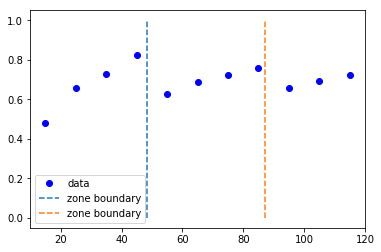

In [16]:
#plot the throughput values (should all be <1 and should increase outward until they hit a zone boundary)
plt.plot(throughput_seps, thrpt_list,'bo', label="data")
for bd in zone_boundaries:
    plt.plot((bd,bd),(0,1),'--',label='zone boundary')
plt.legend()
plt.savefig(outputdir+'/'+prefix+'_throughput')

# Run KLIP on data without fakes and measure contrast

In [17]:
# specify directory and read in data again. This time we will NOT inject fakes
filelist = glob.glob(direc+"/sliced*.fits")
filelist = sorted(filelist, key=len)

In [18]:
## create dataset object for processing
dataset = MagAO.MagAOData(filelist, highpass=False)
## set inner working angle to match previous
dataset.IWA=IWA

reading data, num files:  2212


/Users/kfollette/pyklip/pyklip/instruments/MagAO.py:445: RuntimeWarning: cdelt will be ignored since cd is present
  w.wcs.cdelt = np.array([header['CDELT1'], header['CDELT2']])


In [19]:
#get image units in terms of contrast rather than counts by dividing each image by the star peak
for i in np.arange(0,len(starpeak)):
    dataset.input[i,:,:] /= starpeak[i]

In [20]:
#if need sanity check of what is going into KLIP, uncomment the next line
#fits.writeto('KLIP_input.fits', dataset.input, overwrite=True)

In [21]:
#klip the dataset with same set of KLIP parameters as fake planets
parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=prefix, annuli = numann, subsections = 1, algo = 'klip',
                             movement=movm, numbasis=KLlist, calibrate_flux=False, mode="ADI", highpass=True)

Begin align and scale images for each wavelength
Wavelength 0.642 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 3
Closing threadpool
Derotating Images...
Writing Images to directory /Users/kfollette/Desktop/HD169142_SNRs/contrastcurves


/Users/kfollette/pyklip/pyklip/parallelized.py:1561: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))


In [44]:
##pull some needed info from headers
kl_hdulist = fits.open("{out}/{pre}-KLmodes-all.fits".format(out=outputdir, pre=prefix))
klcube = kl_hdulist[1].data
#first number is KL mode index of cube. Don't change unless you ran multiple KL modes. 
klim=klcube[0,:,:]
klheader = kl_hdulist[0].header
dataset_center = [kl_hdulist[0].header['PSFCENTX'], kl_hdulist[0].header['PSFCENTY'] ]   

In [45]:
##if need to sanity check KLIP output, uncomment line below
#fits.writeto('KLIP_output.fits', dataset.output, overwrite=True)

In [46]:
dataset_owa = 125 # 1" is the furthest out we will go for computing contrast. Can change if needed.
dataset_fwhm = 5.1 # fwhm of PSF. needed for correction for small number statistics

In [47]:
## Uncomment and change parameters if there is a REAL object in your data that needs to be masked
## separation and PA of object
#obj_sep = 30.11 # pixels
#obj_pa = 212.2 # degrees
#obj_x = obj_sep * -np.sin(np.radians(obj_pa)) + dataset_center[0]
#obj_y = obj_sep * np.cos(np.radians(obj_pa)) + dataset_center[1]
## now mask the data
##create xdim x ydim array to store distances from planets
#ydat, xdat = np.indices(klim.shape)
##populate array with distances from planets
#distance_from_planet = np.sqrt((xdat - obj_x)**2 + (ydat - obj_y)**2)
##mask anything within 1.5*FWHM
#klim[np.where(distance_from_planet <= 1.5*dataset_fwhm)] = np.nan

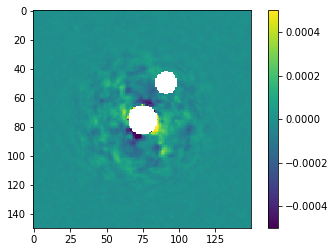

In [48]:
#Another sanity check. Display KLIPed image. Should not have fake planets. Masks hould cover planet if masking. 
#You may wish to change vmin and vmax
cen=int((imsz-1)/2.)
plt.imshow(klim[cen-50:cen+50,cen-50:cen+50],vmin=-0.0005,vmax=0.0005,origin='lower')
plt.colorbar()

In [49]:
#extract contrast values at designated separations
contrast_seps, contrast = klip.meas_contrast(klim, dataset.IWA, dataset_owa, \
                                             dataset_fwhm, 
                                             center=dataset_center, low_pass_filter=False)
#print(contrast_seps, contrast)

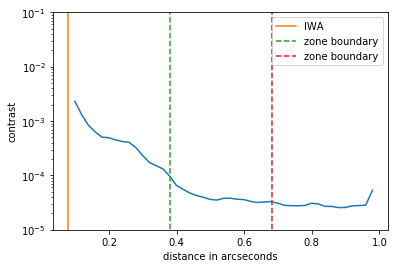

In [50]:
platescale=0.0078513
plt.plot(contrast_seps*platescale, contrast)
#plt.plot(contrast_seps*platescale, contrast, 'bx')
plt.yscale("log")
plt.ylim(1e-5, 1e-1)
plt.xlabel("distance in arcseconds")
plt.ylabel("contrast")
if dataset.IWA > 0:
    plt.plot((dataset.IWA*platescale,dataset.IWA*platescale),(1e-5,1e-1), label='IWA')
for bd in zone_boundaries*platescale:
    plt.plot((bd,bd),(0,1),'--',label='zone boundary')
plt.legend()
plt.savefig(outputdir+'/'+prefix+'_rawcontrast')

# Put them together - Corrected Contrast Curves

In [51]:
corrected_contrast_curve = np.copy(contrast)
for i, sep in enumerate(contrast_seps):
    closest_throughput_index = np.argmin(np.abs(throughput_seps - sep))
    # uncomment next line for sanity check 
    # print('for separation', sep, " closest throughput is at separation ", throughput_seps[closest_throughput_index])
    corrected_contrast_curve[i] /= thrpt_list[closest_throughput_index]

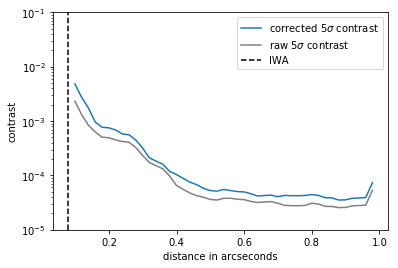

In [52]:
plt.plot(contrast_seps*platescale, corrected_contrast_curve, label='corrected 5$\sigma$ contrast')
plt.plot(contrast_seps*platescale, contrast, label='raw 5$\sigma$ contrast', color='gray')
plt.yscale("log")
plt.ylim(1e-5, 1e-1)
plt.xlabel("distance in arcseconds")
plt.ylabel("contrast")
if dataset.IWA > 0:
    plt.plot((dataset.IWA*platescale,dataset.IWA*platescale),(1e-5,1e-1), 'k--', label='IWA')
#for bd in zone_boundaries*platescale:
 #   plt.plot((bd,bd),(0,1),'--',label='zone boundary')
plt.legend()
plt.savefig(outputdir+'/'+prefix+'_contrastcurve')

In [ ]:
#run snr map and compare value as sanity check
planetspecs = ([20],[187],[4,20])
snr.create_map(klim, fwhm, planets=planetspecs, saveOutput=True, checkmask=True, noisemap=True)